In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from node2vec import Node2Vec
import numpy as np
import random

np.random.seed(42)
random.seed(42)

/Users/liamtessendorf/Programming/Uni/2_Master/3_HS24_Programming/us-congress-members-trading-analysis/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/external/congress_trading_data_adrianmross.csv")

In [3]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["type"] = df["type"].replace({"sale_partial": "sale", "sale_full": "sale"})

In [4]:
df["transaction_date"].min(), df["transaction_date"].max()

(Timestamp('2012-06-19 00:00:00'), Timestamp('2023-12-22 00:00:00'))

## Train-Test Split

In [5]:
dfs_by_year = {year: group for year, group in df.groupby(df["transaction_date"].dt.year)}

In [6]:
def create_graph(df: pd.DataFrame) -> nx.Graph:
    G = nx.Graph()

    party_colors = {"Democrat": "blue", "Republican": "red"}
    party_map = {row["name"]: row["party"] for _, row in df.iterrows()}

    for rep in df["name"].unique():
        G.add_node(
            rep, color=party_colors.get(party_map[rep], "gray")
        )  # Default to gray if party unknown

    for ticker in df["ticker"].unique():
        ticker_trades = df[df["ticker"] == ticker]

        for i in range(len(ticker_trades)):
            for j in range(i + 1, len(ticker_trades)):
                rep1 = ticker_trades.iloc[i]["name"]
                rep2 = ticker_trades.iloc[j]["name"]
                date1 = ticker_trades.iloc[i]["transaction_date"]
                date2 = ticker_trades.iloc[j]["transaction_date"]
                trans_type1 = ticker_trades.iloc[i]["type"]
                trans_type2 = ticker_trades.iloc[j]["type"]

                if rep1 != rep2 and abs((date1 - date2).days) <= 7 and trans_type1 == trans_type2:
                    G.add_edge(rep1, rep2, stock=ticker)

    return G

In [7]:
graphs_by_year = {year: create_graph(df_year) for year, df_year in dfs_by_year.items()}

In [8]:
def export_graph(folder, filename, file) -> None:
    os.makedirs(folder, exist_ok=True)
    nx.write_gml(file, f"../{folder}/{filename}")
    print(f"GML file saved as {folder}/{filename}")

In [9]:
def plot_graph(G, year):
    plt.figure(figsize=(12, 12))

    pos = nx.spring_layout(G, seed=42, k=1.5)

    node_colors = [data["color"] for _, data in G.nodes(data=True)]

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, edgecolors="black")
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    plt.title(year)
    plt.axis("off")
    plt.show()

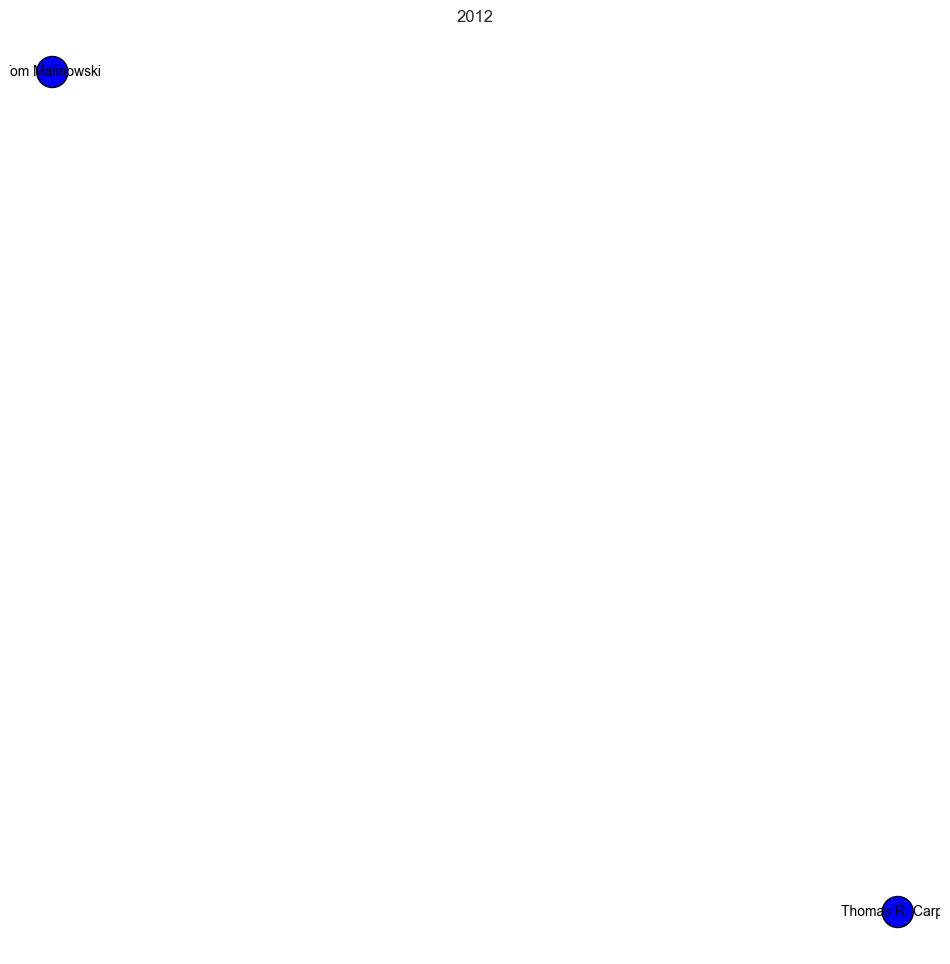

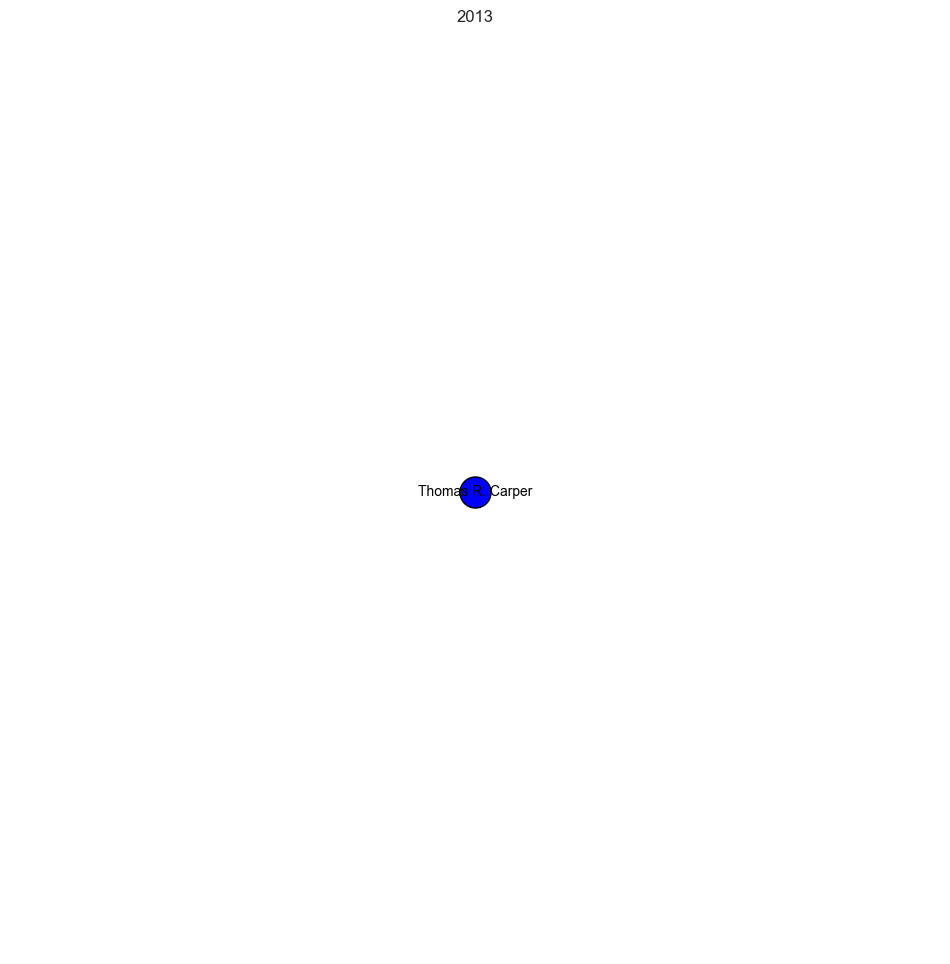

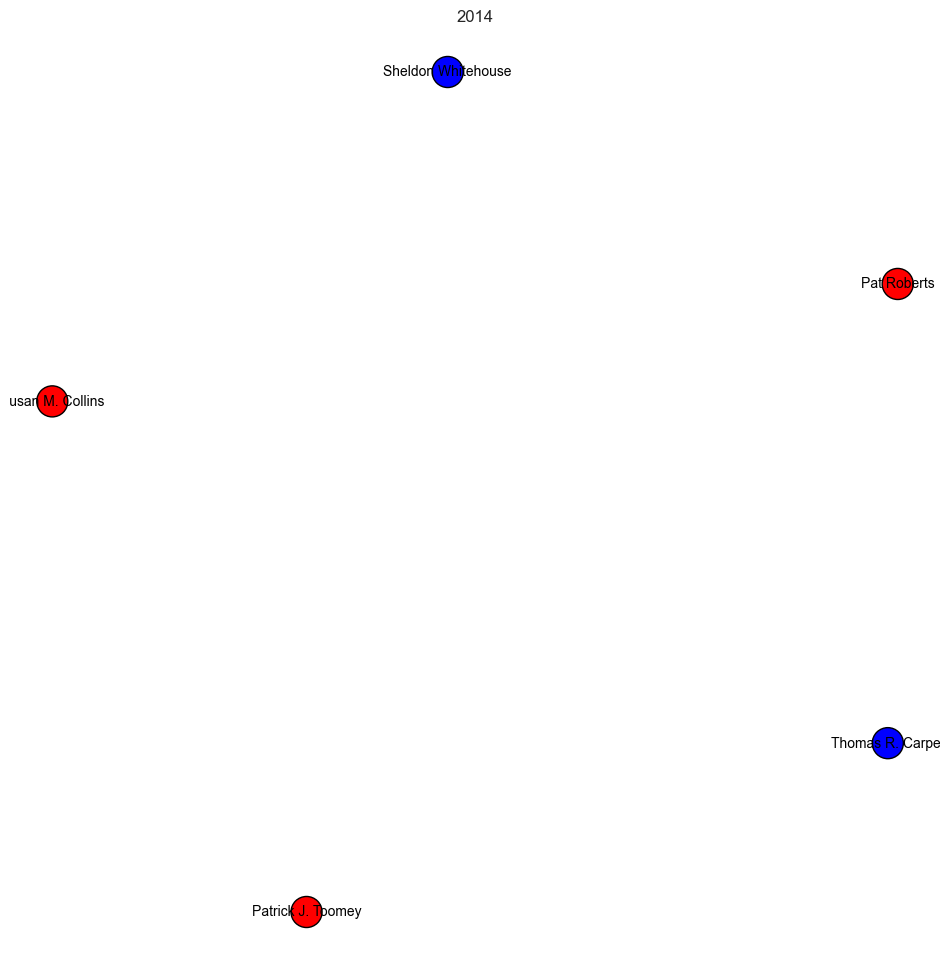

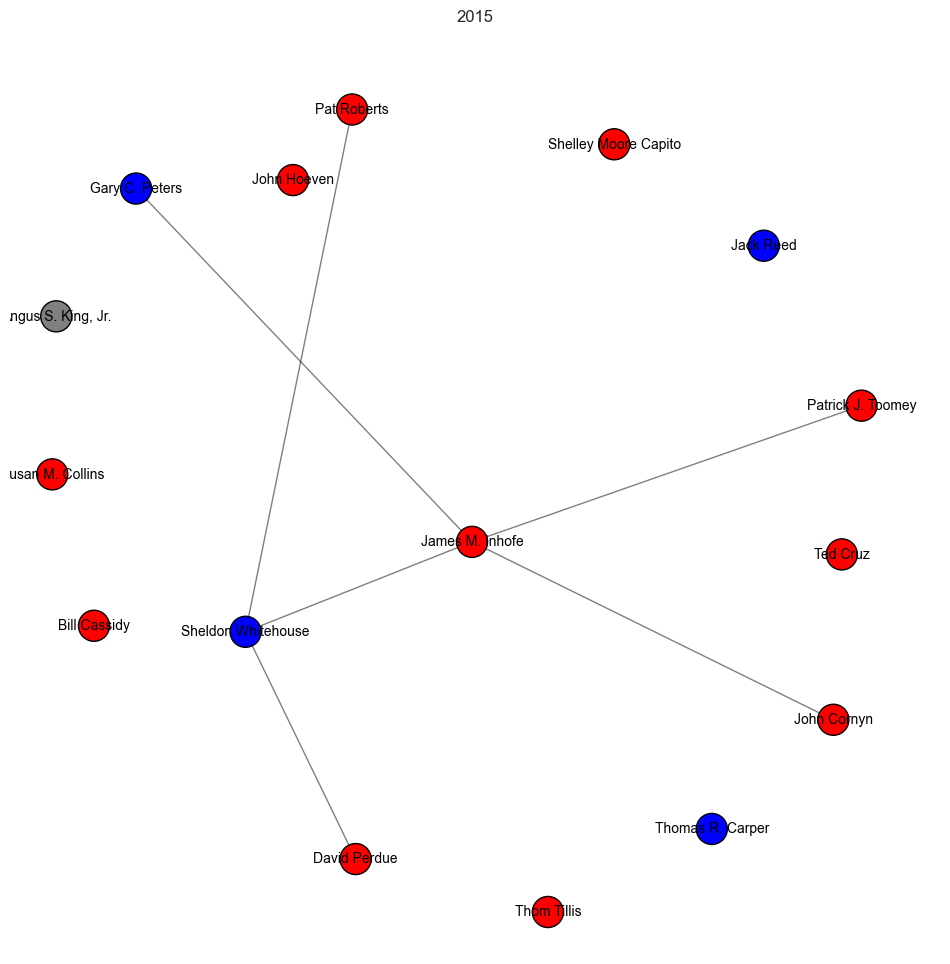

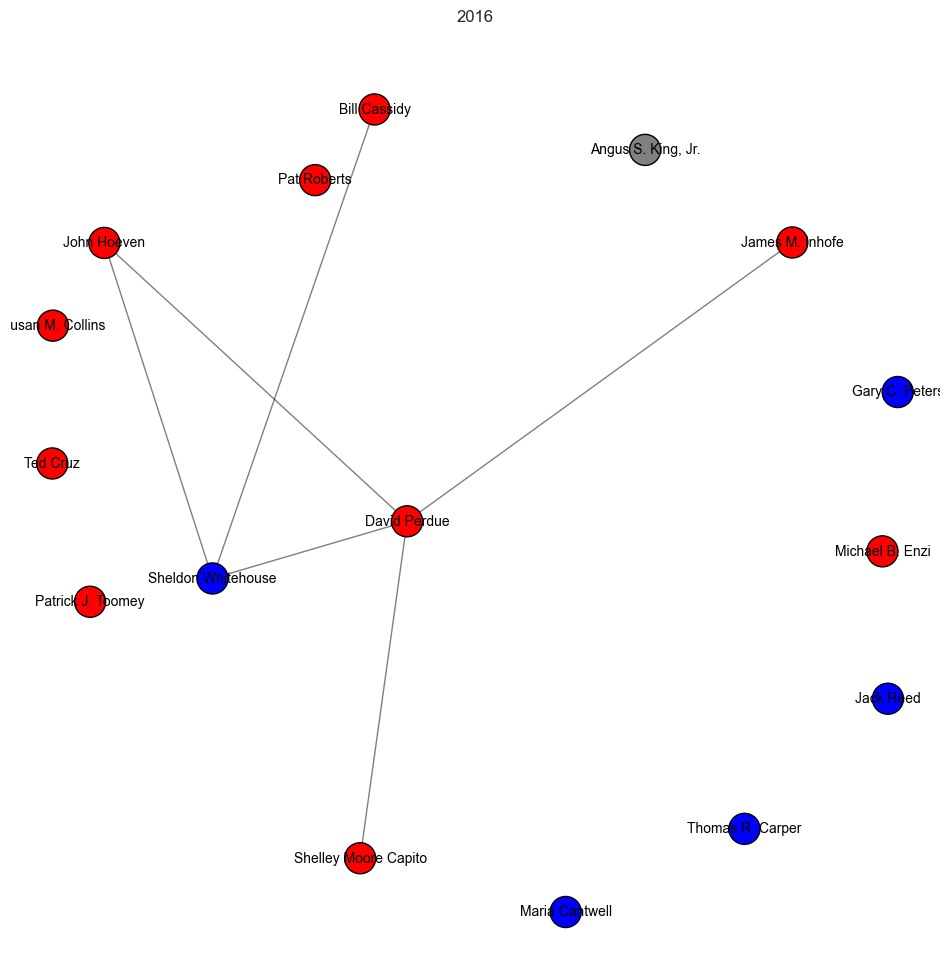

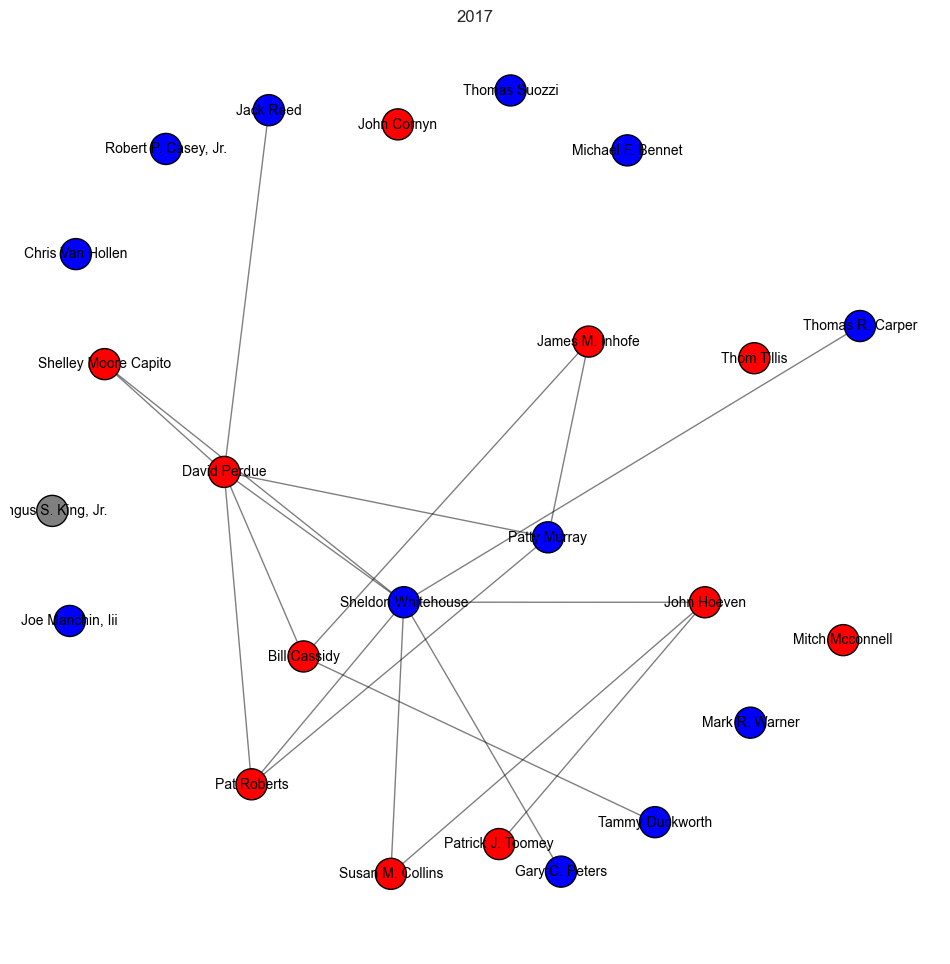

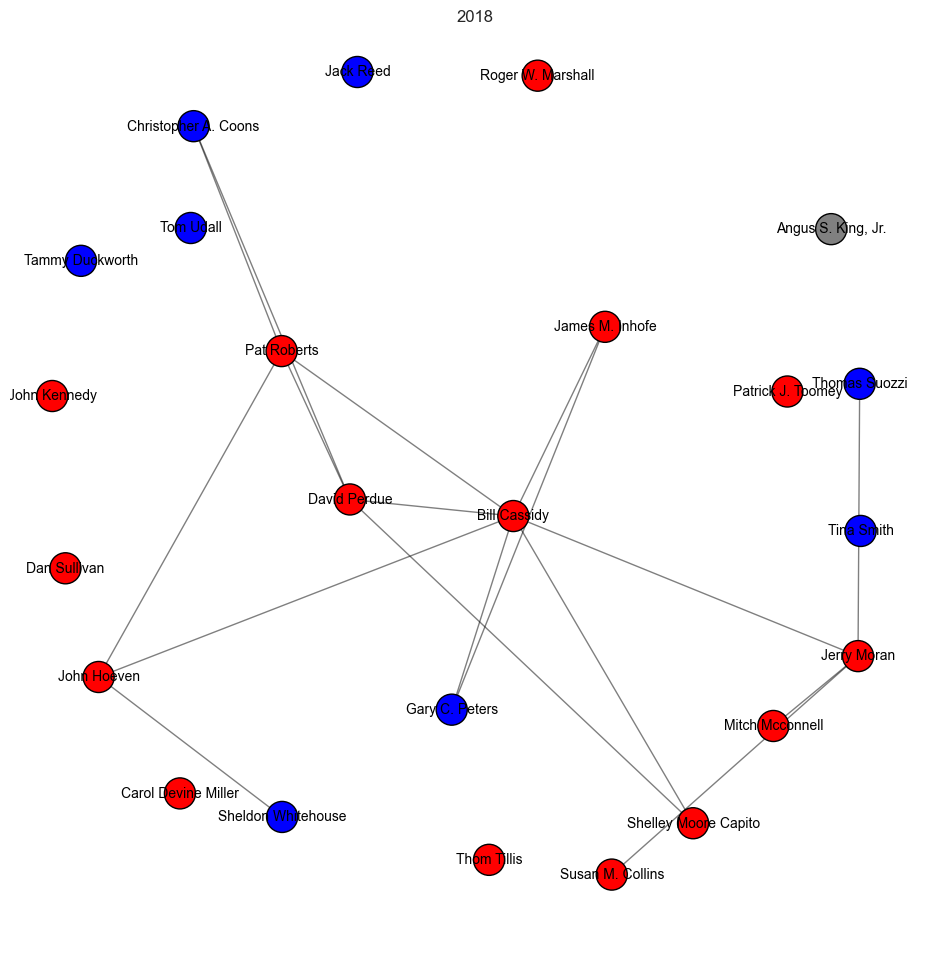

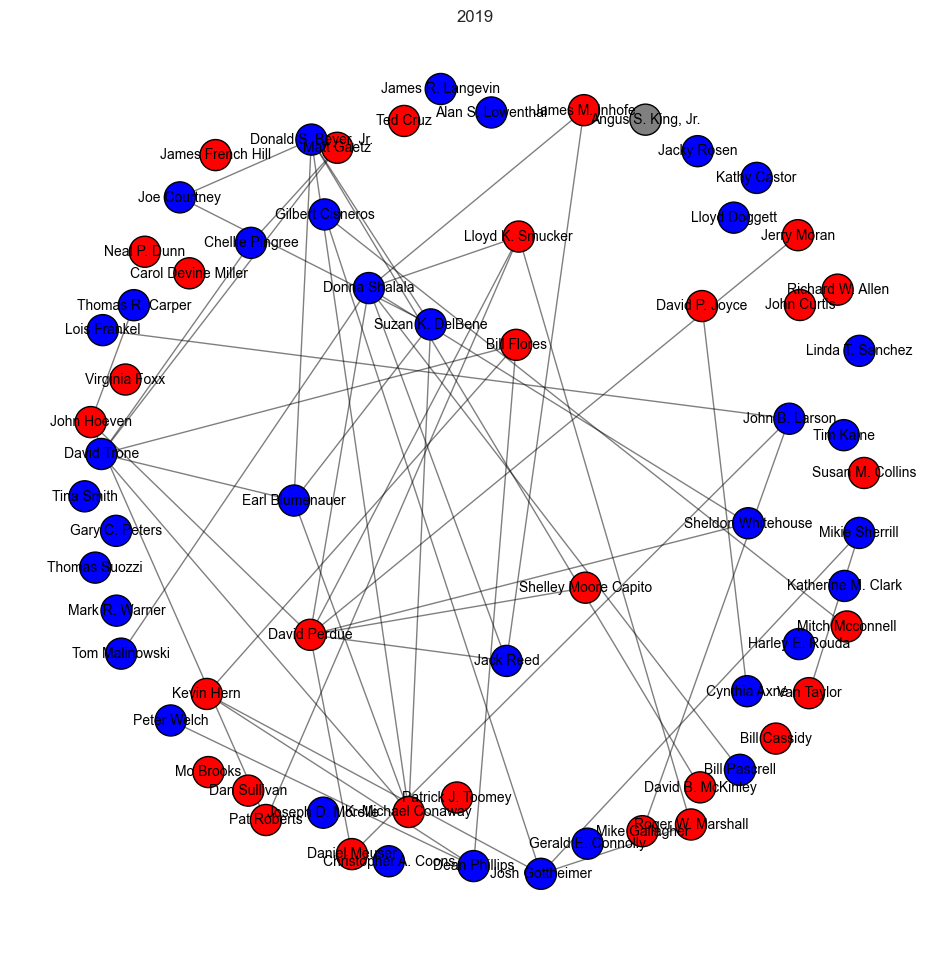

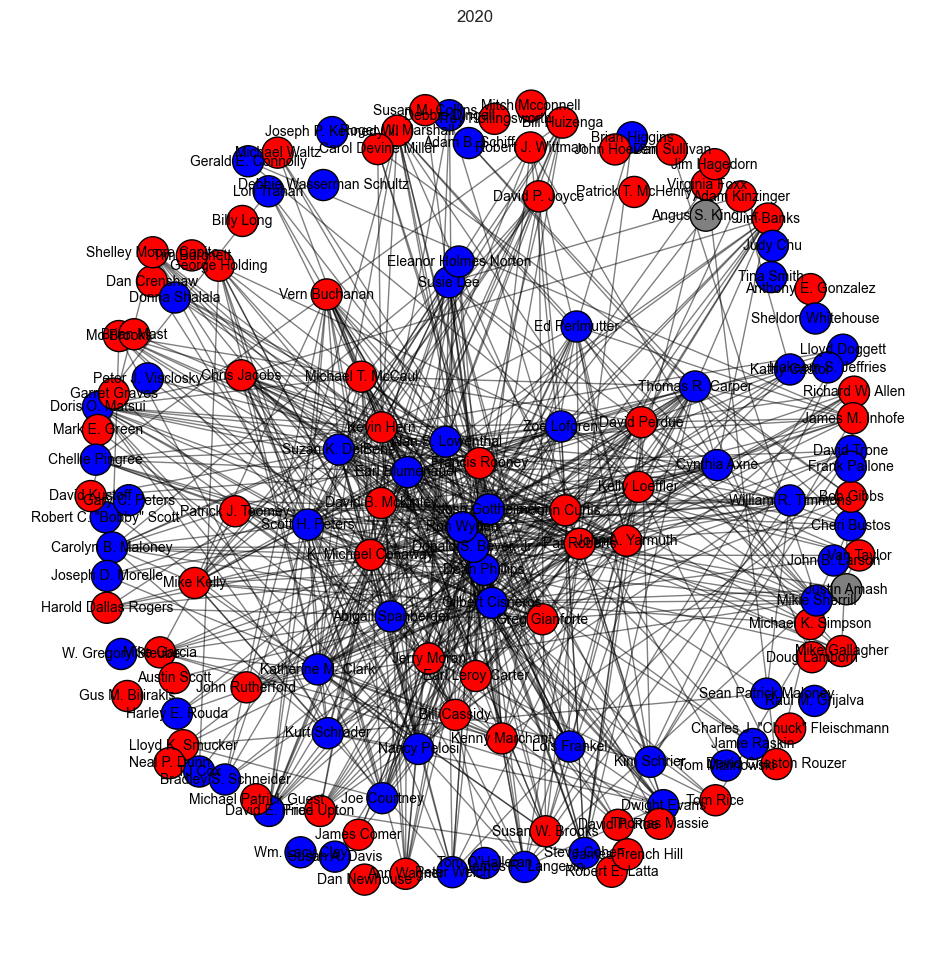

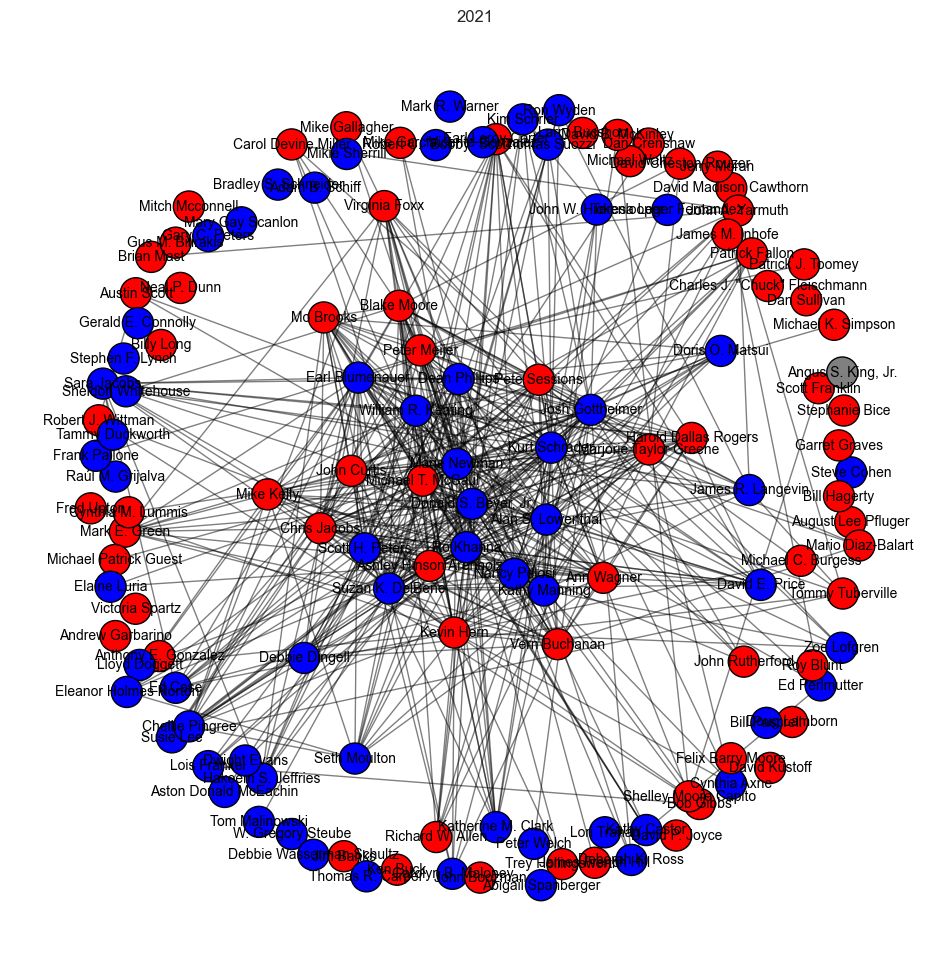

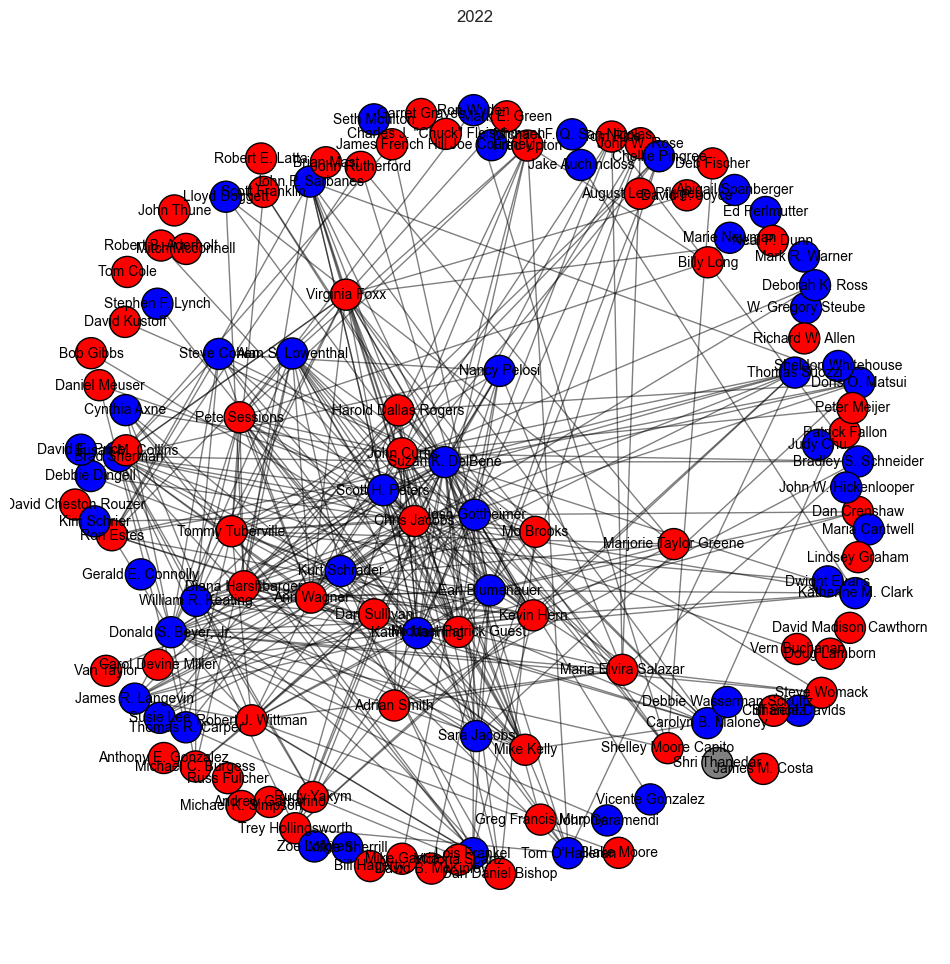

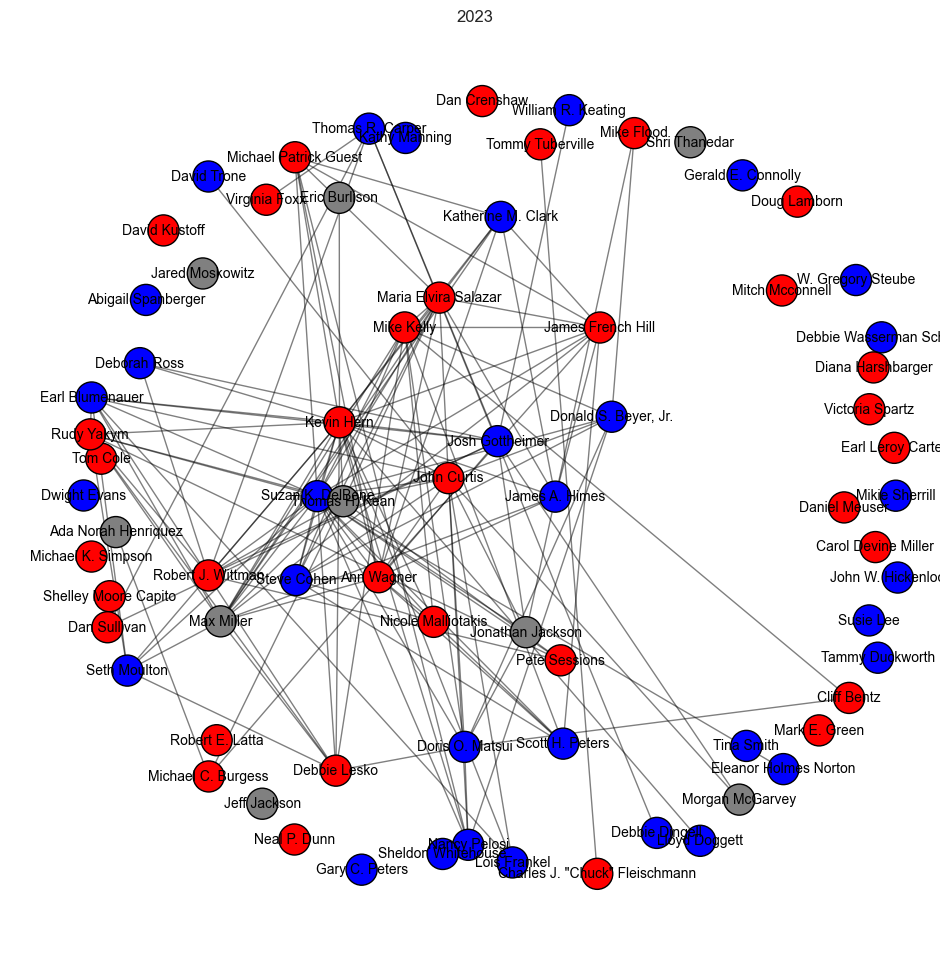

In [10]:
for year, g in graphs_by_year.items():
    plot_graph(g, year)

In [11]:
for year, graph in graphs_by_year.items():
    print(year, graph.number_of_edges())

2012 0
2013 0
2014 0
2015 6
2016 6
2017 18
2018 17
2019 48
2020 720
2021 506
2022 349
2023 140


2015 6
2016 6
2017 18
2018 17
2019 48
2020 720
2021 506
2022 349
2023 140

Probably makes sense to remove years 2015 and 2016 too...

## Create Embeddings using Node2Vec

In [24]:
def create_embeddings(graph):
    node2vec = Node2Vec(graph, dimensions=16, walk_length=15, num_walks=100, workers=1, seed=1)
    model = node2vec.fit(window=10, min_count=1)

    embeddings = pd.DataFrame(
        [model.wv.get_vector(str(node)) for node in graph.nodes()], index=graph.nodes
    )
    embeddings.index.name = "name"
    embeddings.reset_index(inplace=True)
    return embeddings

In [25]:
embeddings_by_year = {year: create_embeddings(graph) for year, graph in graphs_by_year.items()}

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:00<00:00, 877.34it/s]


In [26]:
df_returns = pd.read_csv("../data/external/congress_returns_adrianmross.csv")
df_returns["date"] = pd.to_datetime(df_returns["date"])
df_returns = df_returns[df_returns["date"].dt.year > 2016]
print(df_returns.head())

                 name       date    return  cum_return
0  Abigail Spanberger 2021-06-01  0.000000    0.000000
1  Abigail Spanberger 2021-06-02  0.007044    0.007044
2  Abigail Spanberger 2021-06-03  0.005578    0.012662
3  Abigail Spanberger 2021-06-04  0.012776    0.025600
4  Abigail Spanberger 2021-06-05  0.000000    0.025600


In [27]:
member_active_periods = (
    df_returns.groupby("name")
    .agg(start_date=("date", "min"), end_date=("date", "max"))
    .reset_index()
)


def calculate_yearly_returns(returns_df):
    returns_df["year"] = returns_df["date"].dt.year

    yearly_metrics = returns_df.groupby(["name", "year"]).agg({"return": ["mean", "std", "sum"]})
    yearly_metrics.columns = ["avg_return", "return_volatility", "cumulative_return"]
    yearly_metrics.reset_index(inplace=True)

    return yearly_metrics


historical_returns = calculate_yearly_returns(df_returns)
historical_returns = pd.merge(historical_returns, member_active_periods, on="name", how="left")

we need to normalize the cum. return b.c. not all members have been active for the same amount of time.

In [28]:
df_sp500 = pd.read_csv("../data/external/s&p500_returns_adrianmross.csv")
df_sp500["date"] = pd.to_datetime(df_sp500["date"])

In [29]:
def calculate_sp500_cumulative_return(start_date, end_date):
    mask = (df_sp500["date"] >= start_date) & (df_sp500["date"] <= end_date)
    sp500_period = df_sp500.loc[mask]
    cumulative_return = sp500_period["daily_return"].sum()
    return cumulative_return

In [30]:
historical_returns["sp500_cumulative_return"] = historical_returns.apply(
    lambda row: calculate_sp500_cumulative_return(
        max(row["start_date"], pd.Timestamp(f"{row['year']}-01-01")),
        min(row["end_date"], pd.Timestamp(f"{row['year']}-12-31")),
    ),
    axis=1,
)
historical_returns["normalized_return"] = (
    historical_returns["cumulative_return"] - historical_returns["sp500_cumulative_return"]
)

In [31]:
historical_returns_by_year = {year: df for year, df in historical_returns.groupby("year")}
print(historical_returns_by_year)

{2017:                      name  year  avg_return  return_volatility  \
21     Angus S. King, Jr.  2017    0.002662           0.010552   
53           Bill Cassidy  2017    0.000412           0.005191   
169          David Perdue  2017    0.000056           0.004075   
266        Gary C. Peters  2017    0.000429           0.004281   
305             Jack Reed  2017    0.000633           0.005221   
323       James M. Inhofe  2017   -0.000551           0.008477   
357      Joe Manchin, Iii  2017    0.000704           0.010817   
370           John Cornyn  2017    0.000476           0.003971   
384           John Hoeven  2017   -0.000350           0.008190   
540       Mitch Mcconnell  2017    0.001745           0.008973   
565           Pat Roberts  2017   -0.000948           0.014786   
577     Patrick J. Toomey  2017   -0.001204           0.017114   
585          Patty Murray  2017    0.000021           0.002071   
660    Sheldon Whitehouse  2017    0.000491           0.005312   
668

In [32]:
print(embeddings_by_year)

{2012:                name         0         1         2         3         4  \
0    Tom Malinowski -0.003351  0.001478  0.031896  0.056308 -0.058143   
1  Thomas R. Carper  0.017979  0.006199 -0.051783 -0.059055  0.045699   

          5         6         7         8         9        10        11  \
0 -0.044480  0.040368  0.056081 -0.031346 -0.023521  0.046128 -0.009584   
1  0.031689  0.042236  0.004768  0.039693 -0.021284 -0.005915  0.036054   

         12        13        14        15  
0 -0.028354  0.040963 -0.030376 -0.011350  
1 -0.047010 -0.024601 -0.046947 -0.005813  , 2013:                name         0         1         2         3         4  \
0  Thomas R. Carper -0.003351  0.001478  0.031896  0.056308 -0.058143   

         5         6         7         8         9        10        11  \
0 -0.04448  0.040368  0.056081 -0.031346 -0.023521  0.046128 -0.009584   

         12        13        14       15  
0 -0.028354  0.040963 -0.030376 -0.01135  , 2014:                  na

In [33]:
common_years = set(embeddings_by_year.keys()) & set(historical_returns_by_year.keys())
features_by_year = {
    year: pd.merge(
        embeddings_by_year[year], historical_returns_by_year[year], on="name", how="inner"
    )
    for year in common_years
}

In [34]:
all_features = pd.concat(
    features_by_year.values(), keys=features_by_year.keys(), names=["year", "index"]
)

all_features.reset_index(level=1, drop=True, inplace=True)

print(all_features.head())

                    name         0         1         2         3         4  \
year                                                                         
2017       Thomas Suozzi  0.028773 -0.025596  0.017144  0.043375  0.037909   
2017         John Hoeven -0.358941  0.195489  0.190642  0.668007  0.237299   
2017  Sheldon Whitehouse -0.416919  0.229536  0.074489  0.603713 -0.128673   
2017        David Perdue -0.157645  0.312636 -0.237685  0.263006 -0.116190   
2017     James M. Inhofe  0.034582  0.466632 -0.142210  0.324618 -0.321323   

             5         6         7         8  ...        14        15  year  \
year                                          ...                             
2017 -0.046942  0.058640  0.029199  0.024788  ... -0.050809  0.042653  2017   
2017 -0.019141  1.343088 -0.363711 -0.262688  ... -1.254671  0.257618  2017   
2017  0.022882  1.293494  0.011143 -0.016081  ... -0.929649 -0.201503  2017   
2017  0.106964  1.286698  0.137250  0.391951  ... -0.94833

In [35]:
all_features.to_csv("../data/internal/ml/features_by_year.csv", index=False)